<a href="https://colab.research.google.com/github/kushum-coder/2501460_kushum/blob/main/2501460_KushumRana_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Electricity Consumption Prediction (Regression Task)**

*Student Name:* Kushum Rana  
*Student ID:* 2501460
*Module:* 5CS037  

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor


In [4]:
file_path = "/content/drive/MyDrive/Regression Dataset/electricityConsumptionAndProductioction.csv"

df = pd.read_csv(file_path)

# View first 5 rows
df.head()

,DateTime,Consumption,Production,Nuclear,Wind,Hydroelectric,Oil and Gas,Coal,Solar,Biomass
0,2019-01-01 00:00:00,6352,6527,1395,79,1383,1896,1744,0,30
1,2019-01-01 01:00:00,6116,5701,1393,96,1112,1429,1641,0,30
2,2019-01-01 02:00:00,5873,5676,1393,142,1030,1465,1616,0,30
3,2019-01-01 03:00:00,5682,5603,1397,191,972,1455,1558,0,30
4,2019-01-01 04:00:00,5557,5454,1393,159,960,1454,1458,0,30


In [ ]:
print("===== DATASET INFO =====")
print(df.info())

print("\n===== MISSING VALUES =====")
print(df.isnull().sum())

print("\n===== STATISTICAL SUMMARY =====")
print(df.describe())


===== DATASET INFO =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54170 entries, 0 to 54169
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   DateTime       54170 non-null  object
 1   Consumption    54170 non-null  int64 
 2   Production     54170 non-null  int64 
 3   Nuclear        54170 non-null  int64 
 4   Wind           54170 non-null  int64 
 5   Hydroelectric  54170 non-null  int64 
 6   Oil and Gas    54170 non-null  int64 
 7   Coal           54170 non-null  int64 
 8   Solar          54170 non-null  int64 
 9   Biomass        54170 non-null  int64 
dtypes: int64(9), object(1)
memory usage: 4.1+ MB
None

===== MISSING VALUES =====
DateTime         0
Consumption      0
Production       0
Nuclear          0
Wind             0
Hydroelectric    0
Oil and Gas      0
Coal             0
Solar            0
Biomass          0
dtype: int64

===== STATISTICAL SUMMARY =====
        Consumption    Producti

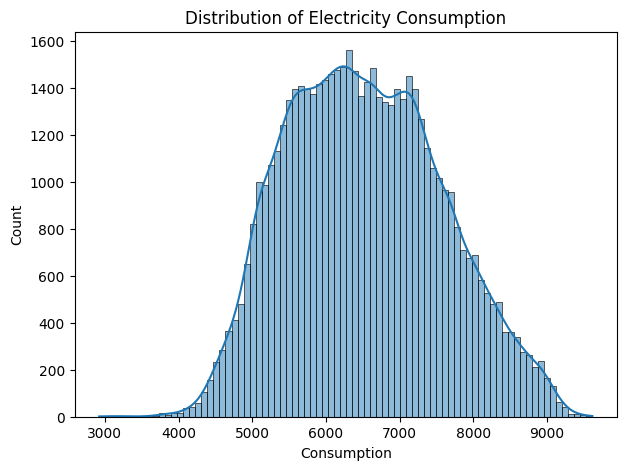

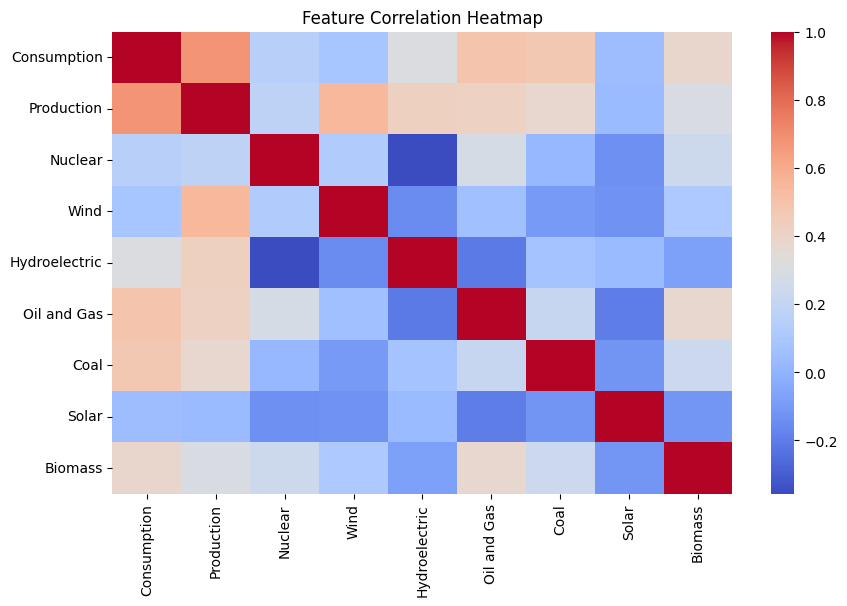

In [5]:
# ---------- REQUIRED EDA VISUALIZATIONS ----------

import seaborn as sns

# Distribution of target variable
plt.figure(figsize=(7,5))
sns.histplot(df["Consumption"], kde=True)
plt.title("Distribution of Electricity Consumption")
plt.xlabel("Consumption")
plt.show()

# Correlation heatmap (numeric features only)
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=False, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()


In [ ]:
print("Columns in dataset:\n", df.columns)


Columns in dataset:
 Index(['DateTime', 'Consumption', 'Production', 'Nuclear', 'Wind',
       'Hydroelectric', 'Oil and Gas', 'Coal', 'Solar', 'Biomass'],
      dtype='object')


In [9]:


# First check if column exists
if "DateTime" in df.columns:
    df["DateTime"] = pd.to_datetime(df["DateTime"])

    df["hour"] = df["DateTime"].dt.hour
    df["day"] = df["DateTime"].dt.day
    df["month"] = df["DateTime"].dt.month
    df["weekday"] = df["DateTime"].dt.weekday

    # Drop original DateTime
    df = df.drop(columns=["DateTime"])

else:
    print("DateTime column already dropped — skipping this step.")


DateTime column already dropped — skipping this step.


In [11]:
target = "Consumption"

X = df.drop(columns=[target])
y = df[target]

print("X columns:", X.columns.tolist())
print("X shape:", X.shape)
print("y shape:", y.shape)

X columns: ['Production', 'Nuclear', 'Wind', 'Hydroelectric', 'Oil and Gas', 'Coal', 'Solar', 'Biomass', 'hour', 'day', 'month', 'weekday']
X shape: (54170, 12)
y shape: (54170,)


In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])


Training samples: 43336
Testing samples: 10834


In [14]:
# Identify numerical and categorical columns
num_features = X.select_dtypes(include=['int64', 'float64']).columns
cat_features = X.select_dtypes(include=['object']).columns

print("Numerical features:", num_features)
print("Categorical features:", cat_features)

# DEFINE PREPROCESSOR (THIS WAS MISSING IN YOUR SESSION)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
])


Numerical features: Index(['Production', 'Nuclear', 'Wind', 'Hydroelectric', 'Oil and Gas', 'Coal',
       'Solar', 'Biomass'],
      dtype='object')
Categorical features: Index([], dtype='object')


In [15]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

lr_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LinearRegression())
])

# Train model
lr_pipeline.fit(X_train, y_train)

# Predictions
y_pred_lr = lr_pipeline.predict(X_test)

# Evaluation
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print("==== LINEAR REGRESSION RESULTS ====")
print("MAE:", mae_lr)
print("RMSE:", rmse_lr)
print("R² Score:", r2_lr)


==== LINEAR REGRESSION RESULTS ====
MAE: 501.45003840401176
RMSE: 632.2193246053739
R² Score: 0.6357977776391253


In [ ]:


best_rf = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(
        n_estimators=50,        # reduced from 100
        max_depth=10,           # limited depth
        min_samples_split=5,    # simpler splits
        max_samples=0.7,        # uses only 70% of data per tree
        random_state=42,
        n_jobs=-1
    ))
])

best_rf.fit(X_train, y_train)

print("Fast Random Forest trained successfully.")


Fast Random Forest trained successfully.


In [ ]:
y_pred_rf = best_rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("==== RANDOM FOREST RESULTS ====")
print("MAE:", mae_rf)
print("RMSE:", rmse_rf)
print("R² Score:", r2_rf)


==== RANDOM FOREST RESULTS ====
MAE: 390.4046834032274
RMSE: 504.1434510963076
R² Score: 0.7684123911851208


In [ ]:
lr_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LinearRegression())
])

lr_pipeline.fit(X_train, y_train)

# Predictions
y_pred_lr = lr_pipeline.predict(X_test)

# Evaluation
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print("==== LINEAR REGRESSION RESULTS ====")
print("MAE:", mae_lr)
print("RMSE:", rmse_lr)
print("R² Score:", r2_lr)


==== LINEAR REGRESSION RESULTS ====
MAE: 501.3920476160415
RMSE: 632.1990018737918
R² Score: 0.635821191871359


In [ ]:
from sklearn.model_selection import cross_val_score

cv_rf = np.mean(cross_val_score(best_rf, X_train, y_train, cv=5, scoring="r2"))
cv_lr = np.mean(cross_val_score(lr_pipeline, X_train, y_train, cv=5, scoring="r2"))

print("Random Forest CV Score:", cv_rf)
print("Linear Regression CV Score:", cv_lr)


Random Forest CV Score: 0.7678552457395507
Linear Regression CV Score: 0.6300067298137918


In [ ]:
# Extract feature names after preprocessing
feature_names = preprocessor.get_feature_names_out()

# Get feature importance from Random Forest
rf_model = best_rf.named_steps["model"]
importances = rf_model.feature_importances_

# Create dataframe
feat_imp_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print(feat_imp_df.head(10))


                                 Feature  Importance
0                        num__Production    0.574598
4                       num__Oil and Gas    0.100775
5                              num__Coal    0.098805
2                              num__Wind    0.071704
7                           num__Biomass    0.041750
3                     num__Hydroelectric    0.039222
1                           num__Nuclear    0.037728
6                             num__Solar    0.025564
41550  cat__DateTime_2024-12-10 09:00:00    0.000087
41065  cat__DateTime_2024-11-13 07:00:00    0.000083


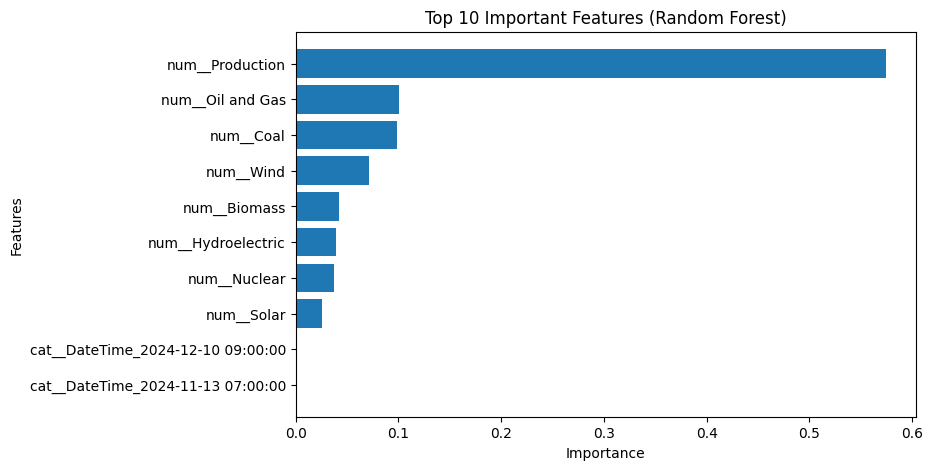

In [ ]:
import matplotlib.pyplot as plt

top_features = feat_imp_df.head(10)

plt.figure(figsize=(8,5))
plt.barh(top_features["Feature"], top_features["Importance"])
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Top 10 Important Features (Random Forest)")
plt.gca().invert_yaxis()
plt.show()


In [ ]:
results_table = pd.DataFrame({
    "Model": ["Random Forest", "Linear Regression"],
    "CV Score (R2)": [cv_rf, cv_lr],
    "MAE": [mae_rf, mae_lr],
    "RMSE": [rmse_rf, rmse_lr],
    "R2 Score": [r2_rf, r2_lr]
})

print(results_table)


               Model  CV Score (R2)         MAE        RMSE  R2 Score
0      Random Forest       0.767855  390.404683  504.143451  0.768412
1  Linear Regression       0.630007  501.392048  632.199002  0.635821


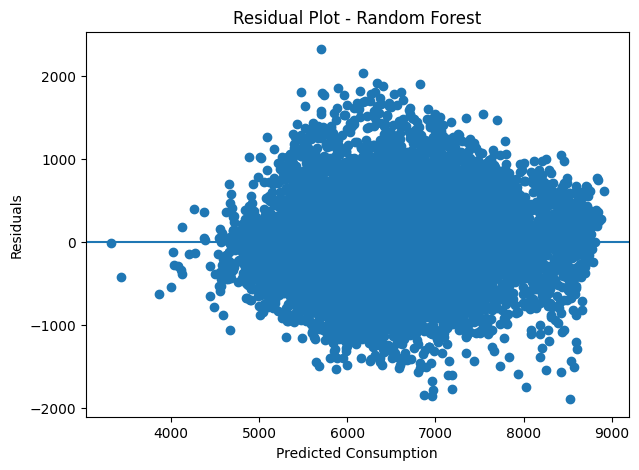

In [ ]:
import matplotlib.pyplot as plt

residuals = y_test - y_pred_rf

plt.figure(figsize=(7,5))
plt.scatter(y_pred_rf, residuals)
plt.axhline(y=0)
plt.xlabel("Predicted Consumption")
plt.ylabel("Residuals")
plt.title("Residual Plot - Random Forest")
plt.show()
